<a href="https://colab.research.google.com/github/yaswanthkumargothi/Portfolio/blob/master/Movie_recommender_system.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!pip install -q tensorflow-recommenders
!pip install -q --upgrade tensorflow-datasets

# Movie Recommendation System - *Sequential Experimental Design*


The structure of this notebook is as follows,

1. EDA
2. Baseline model for movie recommendations using explicit feedback
3. Item-based model using explicit feedback
4. Hybrid model using implicit feedback 
5. Adding context variables and building Deep models using Tensorflow Recommenders 
7. Conclusion

In [2]:
from typing import Dict, Text

import matplotlib.pyplot as plt
import seaborn as sns

import numpy as np
import pandas as pd
import tensorflow as tf

import tensorflow_datasets as tfds
import tensorflow_recommenders as tfrs

In [10]:
# Ratings data.
ratings = tfds.load('movielens/100k-ratings', split="train")
# Features of all the available movies.
movies = tfds.load('movielens/100k-movies', split="train")

Data: 

u.data     -- The full u.data set, 100000 ratings by 943 users on 1682 items.
              Each user has rated at least 20 movies.  Users and items are
              numbered consecutively from 1.  The data is randomly
              ordered.   
            This is a tab separated list of     
	          user id | item id | rating | timestamp. 
              
The time stamps are unix seconds since 1/1/1970 UTC  

## EDA

In [ ]:
# ratings
tfds.as_dataframe(ratings.take(2))

,bucketized_user_age,movie_genres,movie_id,movie_title,raw_user_age,timestamp,user_gender,user_id,user_occupation_label,user_occupation_text,user_rating,user_zip_code
0,45.000000,[7],b'357',"b""One Flew Over the Cuckoo's Nest (1975)""",46.000000,879024327,True,b'138',4,b'doctor',4.000000,b'53211'
1,25.000000,[ 4 14],b'709',b'Strictly Ballroom (1992)',32.000000,875654590,True,b'92',5,b'entertainment',2.000000,b'80525'


In [ ]:
#movies
tfds.as_dataframe(movies.take(4))

,movie_genres,movie_id,movie_title
0,[4],b'1681',b'You So Crazy (1994)'
1,[4 7],b'1457',b'Love Is All There Is (1996)'
2,[1 3],b'500',b'Fly Away Home (1996)'
3,[0],b'838',b'In the Line of Duty 2 (1987)'


In [ ]:
# converting Tensorflow Dataset into a DataFrame for plotting

ratings_df = tfds.as_dataframe(ratings)
movies_df =  tfds.as_dataframe(movies)

In [ ]:
df=pd.merge(ratings_df,movies_df,on="movie_id")

In [ ]:
df.columns

Index(['bucketized_user_age', 'movie_genres_x', 'movie_id', 'movie_title_x',
       'raw_user_age', 'timestamp', 'user_gender', 'user_id',
       'user_occupation_label', 'user_occupation_text', 'user_rating',
       'user_zip_code', 'movie_genres_y', 'movie_title_y'],
      dtype='object')

In [ ]:
#missing values
df.isna().sum()

bucketized_user_age      0
movie_genres_x           0
movie_id                 0
movie_title_x            0
raw_user_age             0
timestamp                0
user_gender              0
user_id                  0
user_occupation_label    0
user_occupation_text     0
user_rating              0
user_zip_code            0
movie_genres_y           0
movie_title_y            0
dtype: int64

In [ ]:
#total number of unique users 
len(df["user_id"].unique())

943

In [ ]:
#total number of unique movies
len(df["movie_title_x"].unique())

1664

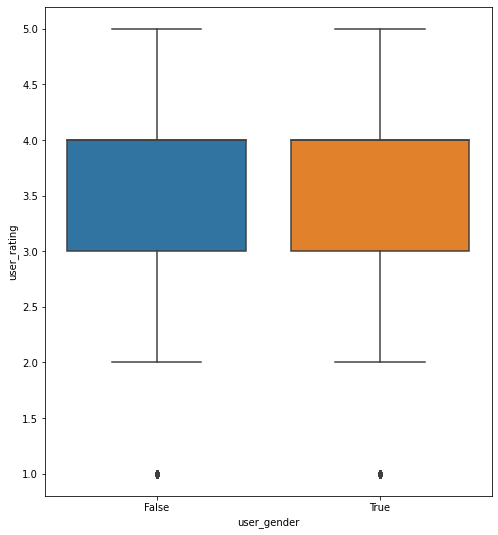

In [ ]:
#genders vs rating
fig,ax=plt.subplots(figsize=(8,9))
ax = sns.boxplot(y="user_rating", x="user_gender", data= df)
ax.set_title("gender Vs user rating distribution plot")

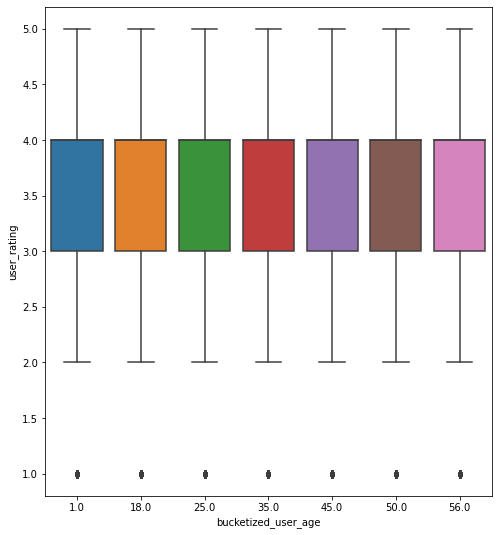

In [ ]:
#user_rating vs bucketized user age
fig,ax=plt.subplots(figsize=(8,9))
ax = sns.boxplot(y="user_rating", x="bucketized_user_age", data= df)
ax.set_title("user_rating vs bucketized user age plot")

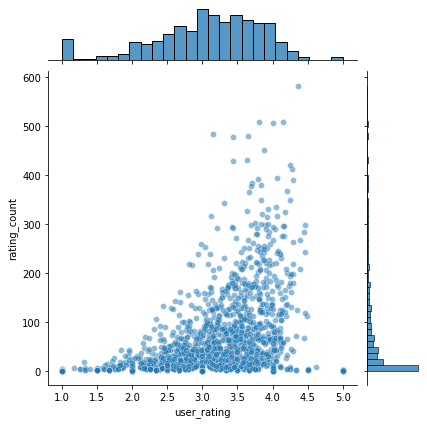

In [ ]:
average_ratings=pd.DataFrame(df.groupby("movie_title_x").mean()['user_rating'])
average_ratings['rating_count']=pd.DataFrame(df.groupby("movie_title_x").count()["user_rating"])
sns.jointplot(x='user_rating',y='rating_count',data=average_ratings,alpha=0.5).set_title("user rating Vs Average movie rating count")


In [ ]:
df["user_zip_code"].value_counts()

b'55414'    1103
b'20009'     878
b'10019'     850
b'22902'     832
b'61820'     817
            ... 
b'17036'      20
b'15017'      20
b'01945'      20
b'93117'      20
b'48043'      20
Name: user_zip_code, Length: 795, dtype: int64

In [2]:
#sparsity = 1 - len(data) / (num_users * num_items)

sparcity = 1 - 100000/(943*1664)
sparcity


0.9362713108736438

In [3]:
#ratings/user
ratings_per_user = 100000/943
ratings_per_item = 100000/1664

print("ratings per user: {}\nratings per item: {}".format(ratings_per_user,ratings_per_item))

ratings per user: 106.04453870625663
ratings per item: 60.09615384615385


Remarks: 

1. No Missing values
2. Data distribution has no significant under representation in age and gender variables.
3. The average movie ratings seems to have slight right skewed guassian distribution. And a large part of movies have less than 100 ratings. Some have more than 500 user ratings.
4. The sparcity is 0.9362
5. Ratings/user 106.04
6. Ratings/item 60.09
7. TFDS dataset has slightly lesser number of movies than the original dataset

## Building baseline using Scikit - Surprise using Explicit feedback

Scikit-Suprise describes itself as a scikit-learn for recommender systems. Though its capabilities are limited, its a good choice for creating a baseline model. 

Scikit-surprise built-in datasets include "Movielens-100k" which can be converted into a dataset object. Though we can convert a pandas DataFrame into Surprise dataset object, it involves using the same methods that "load_builtin" uses to convert built-in dataset. Hence, we loaded our dataset using factory methods.

Explicit Feedback: User generated ratings converted to popular and non popular movies using a threshold


In [28]:
!pip install scikit-surprise

In [43]:
from surprise import SVD
from surprise import Dataset
from surprise.model_selection import cross_validate

# Load the movielens-100k dataset (download it if needed).
data = Dataset.load_builtin('ml-100k')


#inspect data
#data.raw_ratings

# Use the famous SVD algorithm.
algo = SVD()

# Run 5-fold cross-validation and print results.
cross_validate(algo, data, measures=['RMSE', 'MAE'], cv=5, verbose=True)

Evaluating RMSE, MAE of algorithm SVD on 5 split(s).

                  Fold 1  Fold 2  Fold 3  Fold 4  Fold 5  Mean    Std     
RMSE (testset)    0.9391  0.9402  0.9343  0.9342  0.9329  0.9361  0.0029  
MAE (testset)     0.7383  0.7419  0.7367  0.7357  0.7361  0.7377  0.0023  
Fit time          4.87    4.82    4.85    4.80    4.89    4.85    0.03    
Test time         0.16    0.17    0.37    0.17    0.18    0.21    0.08    


{'fit_time': (4.873324871063232,
  4.82437801361084,
  4.852083921432495,
  4.7958033084869385,
  4.8939478397369385),
 'test_mae': array([0.7383396 , 0.74187757, 0.73670579, 0.73572375, 0.73606014]),
 'test_rmse': array([0.93912795, 0.94017865, 0.93430056, 0.93421869, 0.93291132]),
 'test_time': (0.1633610725402832,
  0.16746807098388672,
  0.37161779403686523,
  0.17145252227783203,
  0.17695331573486328)}

To compare, we need a more concrete metric such as precision@K accuracy or recall@k accuracy. So, we create one which we can utilize for other basic recommender systems. 

In [44]:
# sample random trainset and testset
# test set is made of 20% of the ratings.
from surprise.model_selection import train_test_split
trainset, testset = train_test_split(data, test_size=.20)

# Train the algorithm on the trainset, and predict ratings for the testset
algo.fit(trainset)
predictions = algo.test(testset)

In [45]:
def precision_recall_at_k(predictions, k=10, threshold=3.5):
    """Return precision and recall at k metrics for each user"""

    # First map the predictions to each user.
    user_est_true = defaultdict(list)
    for uid, _, true_r, est, _ in predictions:
        user_est_true[uid].append((est, true_r))

    precisions = dict()
    recalls = dict()
    for uid, user_ratings in user_est_true.items():

        # Sort user ratings by estimated value
        user_ratings.sort(key=lambda x: x[0], reverse=True)

        # Number of relevant items
        n_rel = sum((true_r >= threshold) for (_, true_r) in user_ratings)

        # Number of recommended items in top k
        n_rec_k = sum((est >= threshold) for (est, _) in user_ratings[:k])

        # Number of relevant and recommended items in top k
        n_rel_and_rec_k = sum(((true_r >= threshold) and (est >= threshold))
                              for (est, true_r) in user_ratings[:k])

        # Precision@K: Proportion of recommended items that are relevant
        # When n_rec_k is 0, Precision is undefined. We here set it to 0.

        precisions[uid] = n_rel_and_rec_k / n_rec_k if n_rec_k != 0 else 0

        # Recall@K: Proportion of relevant items that are recommended
        # When n_rel is 0, Recall is undefined. We here set it to 0.

        recalls[uid] = n_rel_and_rec_k / n_rel if n_rel != 0 else 0

    return precisions, recalls

In [46]:
from collections import defaultdict
precisions, recalls = precision_recall_at_k(predictions, k=5, threshold=4)

In [47]:
# Precision and recall can then be averaged over all users
print(sum(prec for prec in precisions.values()) / len(precisions))
print(sum(rec for rec in recalls.values()) / len(recalls))

0.6430113234253368
0.2169263879580464


In [48]:
precisions, recalls = precision_recall_at_k(predictions, k=100, threshold=4)

print(sum(prec for prec in precisions.values()) / len(precisions))
print(sum(rec for rec in recalls.values()) / len(recalls))

0.6284149372356801
0.32171498037122837


In [34]:
def get_top_n(predictions, n=10):
    """Return the top-N recommendation for each user from a set of predictions.

    Args:
        predictions(list of Prediction objects): The list of predictions, as
            returned by the test method of an algorithm.
        n(int): The number of recommendation to output for each user. Default
            is 10.

    Returns:
    A dict where keys are user (raw) ids and values are lists of tuples:
        [(raw item id, rating estimation), ...] of size n.
    """

    # First map the predictions to each user.
    top_n = defaultdict(list)
    for uid, iid, true_r, est, _ in predictions:
        top_n[uid].append((iid, est))

    # Then sort the predictions for each user and retrieve the k highest ones.
    for uid, user_ratings in top_n.items():
        user_ratings.sort(key=lambda x: x[1], reverse=True)
        top_n[uid] = user_ratings[:n]

    return top_n

In [35]:
top_n = get_top_n(predictions, n=10)

In [36]:
# Print the recommended items for each user
for uid, user_ratings in top_n.items():
    print(uid, [iid for (iid, _) in user_ratings])
    break

487 ['313', '257', '181', '69', '197', '144', '179', '216', '746', '1']


## Item-based collaborative filtering using KNN

In [37]:
from surprise import KNNBasic
sim_options = {'name': 'cosine',
               'user_based': False  # compute  similarities between items
               }
algo = KNNBasic(sim_options=sim_options)

algo.fit(trainset)
predictions = algo.test(testset)

Computing the cosine similarity matrix...
Done computing similarity matrix.


In [38]:
precisions_KNN, recalls_KNN = precision_recall_at_k(predictions, k=5, threshold=4)

In [39]:
# Precision and recall can then be averaged over all users
print(sum(prec for prec in precisions_KNN.values()) / len(precisions_KNN))
print(sum(rec for rec in recalls_KNN.values()) / len(recalls_KNN))

0.30955414012738897
0.10825334972715896


In [40]:
precisions_KNN, recalls_KNN = precision_recall_at_k(predictions, k=100, threshold=4)

In [41]:
# Precision and recall can then be averaged over all users
print(sum(prec for prec in precisions_KNN.values()) / len(precisions_KNN))
print(sum(rec for rec in recalls_KNN.values()) / len(recalls_KNN))

0.29698792258241963
0.22253235181577344


## LIGHTFM Hybrid recommendation model using implicit feedback

Focusing on ratings in this way ignored the importance of taking into account which movies the users chose to watch in the first place, and treating the absence of ratings as absence of information.

But the things that we don't have ratings for aren't unknowns: we know the user didn't pick them. This reflects a user's conscious choice, and is a good source of information on what she thinks she might like.

This sort of phenomenon is described as data which is missing-not-at-random in the literature: the ratings that are missing are more likely to be negative precisely because the user chooses which items to rate

This observation has led to the development of models that are suitable for implicit feedback. LightFM implements two that have proven particular successful:

**BPR: Bayesian Personalised Ranking** pairwise loss. Maximises the prediction difference between a positive example and a randomly chosen negative example. Useful when only positive interactions are present and optimising ROC AUC is desired.     

**WARP: Weighted Approximate-Rank Pairwise** loss. Maximises the rank of positive examples by repeatedly sampling negative examples until rank violating one is found. Useful when only positive interactions are present and optimising the top of the recommendation list (precision@k) is desired.

LightFM is a Python implementation of a number of popular recommendation algorithms for both implicit and explicit feedback, including efficient implementation of BPR and WARP ranking losses. It's easy to use, fast (via multithreaded model estimation), and produces high quality results.

In [19]:
!pip install lightfm

In [20]:
import numpy as np

from lightfm.datasets import fetch_movielens

movielens = fetch_movielens()

The train and test datasets are generated from the main data file u.data from Movielens. The data sets ua.base, ua.test, split the u.data into a training set and a test set with exactly 10 ratings per user in the test set.  

In [21]:
for key, value in movielens.items():
    print(key, type(value), value.shape)

train <class 'scipy.sparse.coo.coo_matrix'> (943, 1682)
test <class 'scipy.sparse.coo.coo_matrix'> (943, 1682)
item_features <class 'scipy.sparse.csr.csr_matrix'> (1682, 1682)
item_feature_labels <class 'numpy.ndarray'> (1682,)
item_labels <class 'numpy.ndarray'> (1682,)


In [22]:
train = movielens['train']
test = movielens['test']

In [52]:
train.shape
test.shape

(943, 1682)

In [23]:
from lightfm import LightFM
from lightfm.evaluation import precision_at_k
from lightfm.evaluation import auc_score

model = LightFM(learning_rate=0.05, loss='bpr')
model.fit(train, epochs=10)

train_precision = precision_at_k(model, train, k=5).mean()
test_precision = precision_at_k(model, test, k=5).mean()

train_auc = auc_score(model, train).mean()
test_auc = auc_score(model, test).mean()

print('Precision: train %.2f, test %.2f.' % (train_precision, test_precision))
print('AUC: train %.2f, test %.2f.' % (train_auc, test_auc))

Precision: train 0.63, test 0.11.
AUC: train 0.90, test 0.86.


In [24]:
train_precision = precision_at_k(model, train, k=100).mean()
test_precision = precision_at_k(model, test, k=100).mean()

print('Precision: train %.2f, test %.2f.' % (train_precision, test_precision))

Precision: train 0.37, test 0.05.


In [25]:
model = LightFM(learning_rate=0.05, loss='warp')
model.fit(train, epochs=10)

train_precision = precision_at_k(model, train, k=5).mean()
test_precision = precision_at_k(model, test, k=5).mean()

train_auc = auc_score(model, train).mean()
test_auc = auc_score(model, test).mean()

print('Precision: train %.2f, test %.2f.' % (train_precision, test_precision))
print('AUC: train %.2f, test %.2f.' % (train_auc, test_auc))

Precision: train 0.65, test 0.13.
AUC: train 0.94, test 0.90.


In [26]:
train_precision = precision_at_k(model, train, k=100).mean()
test_precision = precision_at_k(model, test, k=100).mean()

print('Precision: train %.2f, test %.2f.' % (train_precision, test_precision))

Precision: train 0.40, test 0.05.


## Tensorflow Recommenders

In [5]:
# Select the basic features.
ratings = ratings.map(lambda x: {
    "movie_title": x["movie_title"],
    "user_id": x["user_id"]
})
movies = movies.map(lambda x: x["movie_title"])

In [ ]:
user_ids_vocabulary = tf.keras.layers.experimental.preprocessing.StringLookup(mask_token=None)
user_ids_vocabulary.adapt(ratings.map(lambda x: x["user_id"]))

movie_titles_vocabulary = tf.keras.layers.experimental.preprocessing.StringLookup(mask_token=None)
movie_titles_vocabulary.adapt(movies)

In [ ]:
class MovieLensModel(tfrs.Model):
  # We derive from a custom base class to help reduce boilerplate. Under the hood,
  # these are still plain Keras Models.

  def __init__(
      self,
      user_model: tf.keras.Model,
      movie_model: tf.keras.Model,
      task: tfrs.tasks.Retrieval):
    super().__init__()

    # Set up user and movie representations.
    self.user_model = user_model
    self.movie_model = movie_model

    # Set up a retrieval task.
    self.task = task

  def compute_loss(self, features: Dict[Text, tf.Tensor], training=False) -> tf.Tensor:
    # Define how the loss is computed.

    user_embeddings = self.user_model(features["user_id"])
    movie_embeddings = self.movie_model(features["movie_title"])

    return self.task(user_embeddings, movie_embeddings)

In [ ]:
# Define user and movie models.
user_model = tf.keras.Sequential([
    user_ids_vocabulary,
    tf.keras.layers.Embedding(user_ids_vocabulary.vocab_size(), 64)
])
movie_model = tf.keras.Sequential([
    movie_titles_vocabulary,
    tf.keras.layers.Embedding(movie_titles_vocabulary.vocab_size(), 64)
])

# Define your objectives.
task = tfrs.tasks.Retrieval(metrics=tfrs.metrics.FactorizedTopK(
    movies.batch(128).map(movie_model)
  )
)

In [ ]:
# Create a retrieval model.
model = MovieLensModel(user_model, movie_model, task)
model.compile(optimizer=tf.keras.optimizers.Adagrad(0.5))

# Train for 3 epochs.
model.fit(ratings.batch(4096), epochs=3)

# Use brute-force search to set up retrieval using the trained representations.
index = tfrs.layers.factorized_top_k.BruteForce(model.user_model)
index.index(movies.batch(100).map(model.movie_model), movies)

# Get some recommendations.
_, titles = index(np.array(["42"]))
print(f"Top 3 recommendations for user 42: {titles[0, :3]}")

Epoch 1/3
25/25 [==============================] - 22s 817ms/step - factorized_top_k/top_1_categorical_accuracy: 3.0000e-05 - factorized_top_k/top_5_categorical_accuracy: 0.0015 - factorized_top_k/top_10_categorical_accuracy: 0.0049 - factorized_top_k/top_50_categorical_accuracy: 0.0453 - factorized_top_k/top_100_categorical_accuracy: 0.1023 - loss: 33080.7426 - regularization_loss: 0.0000e+00 - total_loss: 33080.7426
Epoch 2/3
25/25 [==============================] - 20s 801ms/step - factorized_top_k/top_1_categorical_accuracy: 1.5000e-04 - factorized_top_k/top_5_categorical_accuracy: 0.0055 - factorized_top_k/top_10_categorical_accuracy: 0.0153 - factorized_top_k/top_50_categorical_accuracy: 0.1053 - factorized_top_k/top_100_categorical_accuracy: 0.2124 - loss: 31006.1699 - regularization_loss: 0.0000e+00 - total_loss: 31006.1699
Epoch 3/3
25/25 [==============================] - 20s 803ms/step - factorized_top_k/top_1_categorical_accuracy: 6.2000e-04 - factorized_top_k/top_5_categor

### Adding context and using a Deep learning model 

Many factors affect features beyond ids are useful in a recommender model:

**Importance of context:** if user preferences are relatively stable across contexts and time, context features may not provide much benefit. If, however, users preferences are highly contextual, adding context will improve the model significantly. For example, day of the week may be an important feature when deciding whether to recommend a short clip or a movie: users may only have time to watch short content during the week, but can relax and enjoy a full-length movie during the weekend. Similarly, query timestamps may play an important role in modelling popularity dynamics: one movie may be highly popular around the time of its release, but decay quickly afterwards. Conversely, other movies may be evergreens that are happily watched time and time again.

**Data sparsity:** using non-id features may be critical if data is sparse. With few observations available for a given user or item, the model may struggle with estimating a good per-user or per-item representation. To build an accurate model, other features such as item categories, descriptions, and images have to be used to help the model generalize beyond the training data. This is especially relevant in cold-start situations, where relatively little data is available on some items or users.

The process involves converting user, movie, and time features into embeddings and using the concatenated embeddings to retrieve candidates

In [11]:
ratings = ratings.map(lambda x: {
    "movie_title": x["movie_title"],
    "user_id": x["user_id"],
    "timestamp": x["timestamp"],
})

movies = movies.map(lambda x: x["movie_title"])

In [12]:
timestamps = np.concatenate(list(ratings.map(lambda x: x["timestamp"]).batch(100)))

max_timestamp = timestamps.max()
min_timestamp = timestamps.min()

timestamp_buckets = np.linspace(
    min_timestamp, max_timestamp, num=1000,
)

unique_movie_titles = np.unique(np.concatenate(list(movies.batch(1000))))
unique_user_ids = np.unique(np.concatenate(list(ratings.batch(1_000).map(
    lambda x: x["user_id"]))))

In [13]:
class UserModel(tf.keras.Model):

  def __init__(self, use_timestamps):
    super().__init__()

    self._use_timestamps = use_timestamps

    self.user_embedding = tf.keras.Sequential([
        tf.keras.layers.experimental.preprocessing.StringLookup(
            vocabulary=unique_user_ids, mask_token=None),
        tf.keras.layers.Embedding(len(unique_user_ids) + 1, 32),
    ])

    if use_timestamps:
      self.timestamp_embedding = tf.keras.Sequential([
          tf.keras.layers.experimental.preprocessing.Discretization(timestamp_buckets.tolist()),
          tf.keras.layers.Embedding(len(timestamp_buckets) + 1, 32),
      ])
      self.normalized_timestamp = tf.keras.layers.experimental.preprocessing.Normalization(
          axis=None
      )

      self.normalized_timestamp.adapt(timestamps)

  def call(self, inputs):
    if not self._use_timestamps:
      return self.user_embedding(inputs["user_id"])

    return tf.concat([
        self.user_embedding(inputs["user_id"]),
        self.timestamp_embedding(inputs["timestamp"]),
        tf.reshape(self.normalized_timestamp(inputs["timestamp"]), (-1, 1)),
    ], axis=1)

In [14]:
class MovieModel(tf.keras.Model):

  def __init__(self):
    super().__init__()

    max_tokens = 10_000

    self.title_embedding = tf.keras.Sequential([
      tf.keras.layers.experimental.preprocessing.StringLookup(
          vocabulary=unique_movie_titles, mask_token=None),
      tf.keras.layers.Embedding(len(unique_movie_titles) + 1, 32)
    ])

    self.title_vectorizer = tf.keras.layers.experimental.preprocessing.TextVectorization(
        max_tokens=max_tokens)

    self.title_text_embedding = tf.keras.Sequential([
      self.title_vectorizer,
      tf.keras.layers.Embedding(max_tokens, 32, mask_zero=True),
      tf.keras.layers.GlobalAveragePooling1D(),
    ])

    self.title_vectorizer.adapt(movies)

  def call(self, titles):
    return tf.concat([
        self.title_embedding(titles),
        self.title_text_embedding(titles),
    ], axis=1)

In [15]:
class MovielensModel(tfrs.models.Model):

  def __init__(self, use_timestamps):
    super().__init__()
    self.query_model = tf.keras.Sequential([
      UserModel(use_timestamps),
      tf.keras.layers.Dense(32)
    ])
    self.candidate_model = tf.keras.Sequential([
      MovieModel(),
      tf.keras.layers.Dense(32)
    ])
    self.task = tfrs.tasks.Retrieval(
        metrics=tfrs.metrics.FactorizedTopK(
            candidates=movies.batch(128).map(self.candidate_model),
        ),
    )

  def compute_loss(self, features, training=False):
    # We only pass the user id and timestamp features into the query model. This
    # is to ensure that the training inputs would have the same keys as the
    # query inputs. Otherwise the discrepancy in input structure would cause an
    # error when loading the query model after saving it.
    query_embeddings = self.query_model({
        "user_id": features["user_id"],
        "timestamp": features["timestamp"],
    })
    movie_embeddings = self.candidate_model(features["movie_title"])

    return self.task(query_embeddings, movie_embeddings)

In [16]:
tf.random.set_seed(42)
shuffled = ratings.shuffle(100_000, seed=42, reshuffle_each_iteration=False)

train = shuffled.take(80_000)
test = shuffled.skip(80_000).take(20_000)

cached_train = train.shuffle(100_000).batch(2048)
cached_test = test.batch(4096).cache()

In [17]:
model = MovielensModel(use_timestamps=False)
model.compile(optimizer=tf.keras.optimizers.Adagrad(0.1))

model.fit(cached_train, epochs=3)

train_accuracy = model.evaluate(
    cached_train, return_dict=True)["factorized_top_k/top_100_categorical_accuracy"]
test_accuracy = model.evaluate(
    cached_test, return_dict=True)["factorized_top_k/top_100_categorical_accuracy"]

print(f"Top-100 accuracy (train): {train_accuracy:.2f}.")
print(f"Top-100 accuracy (test): {test_accuracy:.2f}.")

Epoch 1/3
Consider rewriting this model with the Functional API.


Consider rewriting this model with the Functional API.


Consider rewriting this model with the Functional API.


Consider rewriting this model with the Functional API.


40/40 [==============================] - 59s 560ms/step - factorized_top_k/top_1_categorical_accuracy: 0.0092 - factorized_top_k/top_5_categorical_accuracy: 0.0172 - factorized_top_k/top_10_categorical_accuracy: 0.0256 - factorized_top_k/top_50_categorical_accuracy: 0.0825 - factorized_top_k/top_100_categorical_accuracy: 0.1475 - loss: 14579.4626 - regularization_loss: 0.0000e+00 - total_loss: 14579.4626
Epoch 2/3
40/40 [==============================] - 25s 560ms/step - factorized_top_k/top_1_categorical_accuracy: 0.0020 - factorized_top_k/top_5_categorical_accuracy: 0.0126 - factorized_top_k/top_10_categorical_accuracy: 0.0251 - factorized_top_k/top_50_categorical_accuracy: 0.1129 - factorized_top_k/top_100_categorical_accuracy: 0.2133 - loss: 14136.2136 - regularization_loss: 0.0000e+00 - total_loss: 14136.2136
Epoch 3/3
40/40 [==============================] - 25s 562ms/step - factorized_top_k/top_1_categorical_accuracy: 0.0021 - factorized_top_k/top_5_categorical_accuracy: 0.0155 

Consider rewriting this model with the Functional API.


5/5 [==============================] - 8s 1s/step - factorized_top_k/top_1_categorical_accuracy: 9.0000e-04 - factorized_top_k/top_5_categorical_accuracy: 0.0076 - factorized_top_k/top_10_categorical_accuracy: 0.0185 - factorized_top_k/top_50_categorical_accuracy: 0.1051 - factorized_top_k/top_100_categorical_accuracy: 0.2131 - loss: 30995.9001 - regularization_loss: 0.0000e+00 - total_loss: 30995.9001
Top-100 accuracy (train): 0.29.
Top-100 accuracy (test): 0.21.


In [18]:
model = MovielensModel(use_timestamps=True)
model.compile(optimizer=tf.keras.optimizers.Adagrad(0.1))

model.fit(cached_train, epochs=3)

train_accuracy = model.evaluate(
    cached_train, return_dict=True)["factorized_top_k/top_100_categorical_accuracy"]
test_accuracy = model.evaluate(
    cached_test, return_dict=True)["factorized_top_k/top_100_categorical_accuracy"]

print(f"Top-100 accuracy (train): {train_accuracy:.2f}.")
print(f"Top-100 accuracy (test): {test_accuracy:.2f}.")

Epoch 1/3
Consider rewriting this model with the Functional API.


Consider rewriting this model with the Functional API.


Consider rewriting this model with the Functional API.


Consider rewriting this model with the Functional API.


40/40 [==============================] - 27s 579ms/step - factorized_top_k/top_1_categorical_accuracy: 0.0059 - factorized_top_k/top_5_categorical_accuracy: 0.0148 - factorized_top_k/top_10_categorical_accuracy: 0.0237 - factorized_top_k/top_50_categorical_accuracy: 0.0811 - factorized_top_k/top_100_categorical_accuracy: 0.1475 - loss: 14605.1664 - regularization_loss: 0.0000e+00 - total_loss: 14605.1664
Epoch 2/3
40/40 [==============================] - 26s 581ms/step - factorized_top_k/top_1_categorical_accuracy: 0.0026 - factorized_top_k/top_5_categorical_accuracy: 0.0154 - factorized_top_k/top_10_categorical_accuracy: 0.0300 - factorized_top_k/top_50_categorical_accuracy: 0.1380 - factorized_top_k/top_100_categorical_accuracy: 0.2513 - loss: 13955.9811 - regularization_loss: 0.0000e+00 - total_loss: 13955.9811
Epoch 3/3
40/40 [==============================] - 26s 577ms/step - factorized_top_k/top_1_categorical_accuracy: 0.0024 - factorized_top_k/top_5_categorical_accuracy: 0.0194 

Consider rewriting this model with the Functional API.


5/5 [==============================] - 5s 987ms/step - factorized_top_k/top_1_categorical_accuracy: 0.0016 - factorized_top_k/top_5_categorical_accuracy: 0.0098 - factorized_top_k/top_10_categorical_accuracy: 0.0220 - factorized_top_k/top_50_categorical_accuracy: 0.1269 - factorized_top_k/top_100_categorical_accuracy: 0.2485 - loss: 30700.6270 - regularization_loss: 0.0000e+00 - total_loss: 30700.6270
Top-100 accuracy (train): 0.36.
Top-100 accuracy (test): 0.25.


# Conclusion

Here, I tried to implement multiple recommendation systems libraries on Movielens-100K dataset. I successfully ran the packages and presented their results. Challenges include creating a single test dataset and comparing the results. As these libraries have their own preprocessing and data conversion steps, it is a challenge to make a test set that is unique for all the packages. With little effort, we have our first recommendation models. 

To do: Ranking steps in TFRS

**Model Comparison and discussion:**

| Model      | Precision@5 | Precision@100    |Feedback|
| :---        |    :----:   |          ---: | |
| SVD      |  0.64      | 0.62   |Explicit |
| KNN   |  0.30       | 0.29      | Explicit|
| LIGHTFM|0.13 | 0.005|Implicit|
|TFRS|0.0076 |0.21 |Implicit |
|TFRS-CONTEXT|0.0098|0.25|Implicit|

* With SVD and KNN on 20% testset data, we could be able to get good precision@k accuracy, but we need to understand that explicit feedback with available users ratings doesn't consider problems such as coldstart, sparsity etc. as discussed above.
* LIGHTFM is the fastest available algorithm. Though it embeds user and item metadata, It is limited in the explainability because it sums up the embeddings unlike in TFRS. As described in the Case-study  document, Its very efficient and scalable and works well for small and medium scale datasets. Here, the reason for low Precision@K might be due to how the test and train datasets generated by the movielens.[needs to be investigated]
* TensorFlow Recommenders(TFRS) is suitable for more complex experimentation such as one described in the Youtube Recommendation system paper. And it comes with end to end serving optimized algorithms. 

To conclude, **TFRS will be a good choice for Movie recommendation.** 

# References:


1. https://www.tensorflow.org/recommenders/examples/quickstart
2. http://surpriselib.com/
3. https://making.lyst.com/lightfm/docs/quickstart.html

***